Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [6]:
num_steps = 801

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 18.901485
Training accuracy: 11.8%
Validation accuracy: 13.7%
Loss at step 100: 2.364669
Training accuracy: 70.8%
Validation accuracy: 70.2%
Loss at step 200: 1.871592
Training accuracy: 74.0%
Validation accuracy: 73.0%
Loss at step 300: 1.607424
Training accuracy: 75.3%
Validation accuracy: 74.0%
Loss at step 400: 1.432018
Training accuracy: 76.3%
Validation accuracy: 74.6%
Loss at step 500: 1.305428
Training accuracy: 77.0%
Validation accuracy: 74.9%
Loss at step 600: 1.209350
Training accuracy: 77.7%
Validation accuracy: 75.1%
Loss at step 700: 1.133087
Training accuracy: 78.1%
Validation accuracy: 75.2%
Loss at step 800: 1.070359
Training accuracy: 78.5%
Validation accuracy: 75.3%
Test accuracy: 83.1%


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {
            tf_train_dataset : batch_data, 
            tf_train_labels : batch_labels
        }
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 15.318331
Minibatch accuracy: 7.8%
Validation accuracy: 13.2%
Test accuracy: 13.3%
Minibatch loss at step 500: 2.429765
Minibatch accuracy: 68.0%
Validation accuracy: 75.9%
Test accuracy: 83.2%
Minibatch loss at step 1000: 1.534487
Minibatch accuracy: 72.7%
Validation accuracy: 77.1%
Test accuracy: 84.5%
Minibatch loss at step 1500: 1.385989
Minibatch accuracy: 71.9%
Validation accuracy: 77.5%
Test accuracy: 85.2%
Minibatch loss at step 2000: 1.260992
Minibatch accuracy: 75.0%
Validation accuracy: 77.4%
Test accuracy: 85.1%
Minibatch loss at step 2500: 1.298825
Minibatch accuracy: 76.6%
Validation accuracy: 79.3%
Test accuracy: 86.0%
Minibatch loss at step 3000: 0.639152
Minibatch accuracy: 80.5%
Validation accuracy: 79.1%
Test accuracy: 86.3%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [9]:
train_dataset.shape

(200000, 784)

In [12]:
image_size = 28
num_labels = 10

def initialize_parameters():
    parameters = {}
    layers_dims = [ image_size**2, 1024, num_labels ]
    
    for l in range(1, len(layers_dims)):
        parameters['W' + str(l)] = tf.Variable(tf.truncated_normal([layers_dims[l-1], layers_dims[l]]))
        parameters['b' + str(l)] = tf.Variable(tf.zeros([layers_dims[l]]))
        
    return parameters

def forward_propagation(X, parameters):
    A = X
    L = len(parameters) // 2 + 1 # number of layers in the neural network
    
    # linear[1] -> relu -> liner[2] -> ... -> relu -> linear[L-1]
    for l in range(1, L):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = tf.add(tf.matmul(A, W), b)
        if (l < L - 1):
            A = tf.nn.relu(Z)
               
    return Z

In [13]:
batch_size = 128
learning_rate= 0.5

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size**2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset) 
    
    parameters = initialize_parameters()
    
    logits = forward_propagation(tf_train_dataset, parameters)
        
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
      
    train_prediction = tf.nn.softmax(forward_propagation(tf_train_dataset, parameters))
    valid_prediction = tf.nn.softmax(forward_propagation(tf_valid_dataset, parameters))
    test_prediction = tf.nn.softmax(forward_propagation(tf_test_dataset, parameters))

In [14]:
num_steps = 3001
costs = []

with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {
            tf_train_dataset : batch_data, 
            tf_train_labels : batch_labels
        }
        _, step_cost, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, step_cost))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        if (step % 5 == 0):
            costs.append(step_cost)

Minibatch loss at step 0: 377.165894
Minibatch accuracy: 6.2%
Validation accuracy: 25.9%
Test accuracy: 27.7%
Minibatch loss at step 500: 26.744843
Minibatch accuracy: 68.8%
Validation accuracy: 78.5%
Test accuracy: 86.0%
Minibatch loss at step 1000: 13.839665
Minibatch accuracy: 77.3%
Validation accuracy: 81.5%
Test accuracy: 88.2%
Minibatch loss at step 1500: 7.114422
Minibatch accuracy: 80.5%
Validation accuracy: 81.8%
Test accuracy: 88.4%
Minibatch loss at step 2000: 8.568427
Minibatch accuracy: 83.6%
Validation accuracy: 81.6%
Test accuracy: 88.2%
Minibatch loss at step 2500: 9.817942
Minibatch accuracy: 72.7%
Validation accuracy: 81.3%
Test accuracy: 88.1%
Minibatch loss at step 3000: 2.148283
Minibatch accuracy: 82.0%
Validation accuracy: 82.0%
Test accuracy: 88.8%


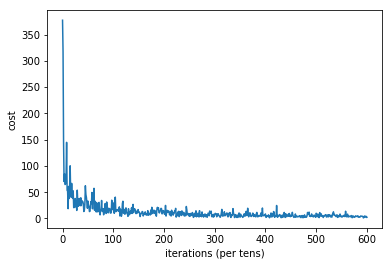

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.show()